# 截面计算

   B - 16.40 ug/cm2     2.350 g/cm3   10.81 g/mol
 11B - 13.12 ug/cm2                      11 g/mol
 10B -  3.28 ug/cm2                      10 g/mol
   C -  6.50 ug/cm2     2.253 g/cm3   12.01 g/mol
  Fe -                  7.866 g/cm3   55.85 g/mol

$\cfrac{N_{sc}(11B+10B)}{N_{sc}(C)} = \cfrac{\cfrac{16.40}{10.81}*\sigma_{sc}(pB)}{\cfrac{6.50}{12.01}*\sigma_{sc}(pC)}$

$\cfrac{N_{sc}(^{11}B+^{10}B+^{12}C)}{N_\alpha(\theta)} = \cfrac{\cfrac{16.40\ ug/cm^2 \times 80.1\%}{11\ g/mol}*\sigma_{sc}(p^{11}B)+\cfrac{16.40\ ug/cm^2 \times 19.9\%}{10\ g/mol}*\sigma_{sc}(p^{10}B)+\cfrac{6.50\ ug/cm^2}{12\ g/mol}*\sigma_{sc}(p^{12}C)}{\cfrac{16.40\ ug/cm^2 \times 80.1\%}{11\ g/mol}*\sigma_\alpha(\theta)}$

$\cfrac{N_{sc}(11B+10B)+N_{sc}(12C)}{N_{sc}(Fe)} = \cfrac{\cfrac{16.40}{10.81}*\sigma_{sc}(pB)+\cfrac{6.50}{12.01}*\sigma_{sc}(pC)}{\cfrac{Fe_{thickness}}{55.85}*\sigma_{sc}(pFe)}$

In [1]:
const int Ep = 1388;  // keV

In [2]:
TFile *ipf = new TFile(Form("anaB_%04dkeV.root",Ep));
TH1I *h;
TCanvas *c1 = new TCanvas;
gStyle->SetOptStat(0);
int theta;

In [3]:
%jsroot on
if (h) delete h;
theta = 125;
h = (TH1I*)ipf->Get(Form("hsingle_%ddeg",theta));
h->GetXaxis()->SetRangeUser(0,4000);
//h->GetYaxis()->SetRangeUser(0,1500);
h->GetXaxis()->SetTitle("E / keV");
h->GetYaxis()->SetTitle("Count / sr");
h->SetTitle(Form("theta = %d #pm 2.5 deg",theta));
h->Draw();
c1->Draw();

In [4]:
vector<double> e;            //e[0]为目标峰，其他为周围峰
double k,b;                  //线性本底参数
double fit_left,fit_right;   //联合拟合范围
double area_left,area_right; //峰面积计算范围

In [5]:
void area(TH1I *h)
{
    c1->Clear();
    h->GetXaxis()->SetRangeUser(550,1350);   //返回全区间，在多次进行拟合时，必须要有这个操作，否则指定的拟合区间将存在问题

    //设置拟合函数：线性本底 + npeaks个高斯函数
    int npeaks = e.size();
    TString sf = "pol1(0)";
    for (int i=0; i<npeaks; i++)
        sf += Form("+gaus(%d)",3*i+2);
    TF1* f = new TF1("f", sf, fit_left, fit_right);
    f->FixParameter(0, b);                         //手动设置线性本底
    f->FixParameter(1, k);
    for (int i=0; i<npeaks; i++){
        f->SetParameter(3*i+2, 1e6);               //峰高
        f->SetParLimits(3*i+2, 1, 1e10);
        f->SetParameter(3*i+3, e[i]);              //峰中心
        f->SetParLimits(3*i+3, e[i]-1, e[i]+1);
        f->SetParameter(3*i+4, 8);                 //峰宽sigma
        f->SetParLimits(3*i+4, 5, 20);
    }
    
    TFitResultPtr fh = h->Fit(f, "QRS");
    f->SetLineColor(kRed);
    f->Draw("same");

    //单独提出线性本底
    TF1 *f1 = new TF1("f1", "pol1", 0, 2000);
    f1->SetParameter(0, f->GetParameter(0));
    f1->SetParameter(1, f->GetParameter(1));
    f1->SetLineColor(kBlue);
    f1->Draw("same");
    
    //提出联合拟合结果中的各个高斯峰
    TF1 *fg[npeaks];
    for (int i=0; i<npeaks; i++){
        fg[i] = new TF1(Form("fg%d",i), "gaus");
        fg[i]->SetParameter(0, f->GetParameter(3*i+2));
        fg[i]->SetParameter(1, f->GetParameter(3*i+3));
        fg[i]->SetParameter(2, f->GetParameter(3*i+4));
    }
    
    //计算峰面积
    int bin1 = h->FindBin(area_left);
    int bin2 = h->FindBin(area_right);
    double nall = h->Integral(bin1, bin2);                     //包含本底的总计数
    
    double x1 = h->GetBinLowEdge(bin1);                        //积分下界
    double x2 = h->GetBinLowEdge(bin2)+h->GetBinWidth(bin2);   //积分上界，注意使用了与TH1完全相等的积分范围
    double nbg = f1->Integral(x1, x2)/h->GetBinWidth(bin2);    //线性本底贡献

    //输出结果
    cout<<"count="<<nall-nbg<<" delta_count="<<sqrt(nall+nbg)<<endl;
    for (int i=0; i<npeaks; i++)
        cout<<i<<" peak="<<fg[i]->GetParameter(1)<<" height="<<fg[i]->GetParameter(0)
        <<" sigma="<<fg[i]->GetParameter(2)<<" contribution="<<fg[i]->Integral(e[i]-500,e[i]+500)/h->GetBinWidth(1)<<'\n';
    
}

In [6]:
%jsroot off

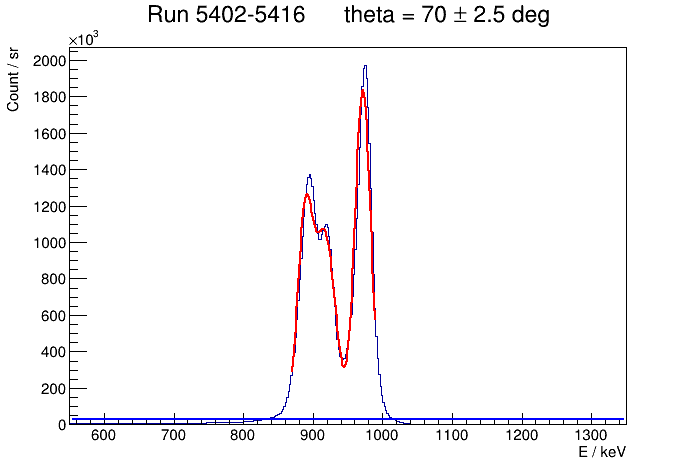

count=5.82623e+07 delta_count=8259.68
0 peak=889 height=1.07051e+06 sigma=10.8872 contribution=1.46072e+07
1 peak=918 height=1.0008e+06 sigma=14.6077 contribution=1.83228e+07
2 peak=972 height=1.80374e+06 sigma=11.2893 contribution=2.55212e+07


In [7]:
e = vector<double> {888, 919, 971};  // 70 deg
//e = vector<double> {834, 878, 960};  // 90 deg
k = 0; b = 30e3;                      //线性本底参数
fit_left = 870; fit_right = 990;       //联合拟合范围  70 deg
//fit_left = 810; fit_right = 980;       //联合拟合范围  90 deg
area_left = 770; area_right = 1100;
area(h);
h->GetXaxis()->SetTitle("E / keV");
h->GetYaxis()->SetTitle("Count / sr");
h->SetTitle("Run 5402-5416      theta = 70 #pm 2.5 deg");
c1->Draw();